一个系统输入不稳定输出稳定,用卷积求系统存量</br>
周围像素点对当前像素点的影响</br>
过滤器</br>

卷积层将输入和核矩阵进行交叉相关，加上偏移后得到输出</br>
核矩阵和偏移是可学习的参数</br>
核矩阵的大小是超参数

# 19图像卷积
互相关运算

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def corr2d(X, K):
    """计算二维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0]-h+1, X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i+h, j:j+w]*K).sum()
    return Y

验证上述二维互相关运算的输出

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

## 实现二维卷积层

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight)+self.bias

卷积层的一个简单应用：通过找到像素变化的位置，来检测图像中不同颜色的边缘

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造一个高度为1、宽度为2的卷积核K。当进行互相关运算时，如果水平相邻的两元素相同，则输出为零，否则输出为非零。

In [5]:
K = torch.tensor([[1.0, -1.0]])

现在，我们对参数X（输入）和K（卷积核）执行互相关运算。 如下所示，输出Y中的1代表从白色到黑色的边缘，-1代表从黑色到白色的边缘，其他情况的输出为0

In [6]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在我们将输入的二维图像转置，再进行如上的互相关运算。 其输出如下，之前检测到的垂直边缘消失了。 不出所料，这个卷积核K只可以检测垂直边缘，无法检测水平边缘。

In [7]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

## 学习卷积核
学习由X生成Y的卷积核</br>
我们先构造一个卷积层，并将其卷积核初始化为随机张量。接下来，在每次迭代中，我们比较Y与卷积层输出的平方误差，然后计算梯度来更新卷积核。为了简单起见，我们在此使用内置的二维卷积层，并忽略偏置。

In [8]:
# 构造一个二维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)  # 输入通道 输出通道

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)
lr = 3e-2  # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat-Y)**2
    conv2d.zero_grad()
    l.sum().backward()
    conv2d.weight.data[:] -= lr*conv2d.weight.grad
    if (i+1) % 2 == 0:
        print(f'epoch {i+1},loss {l.sum():.3f}')

epoch 2,loss 1.941
epoch 4,loss 0.410
epoch 6,loss 0.103
epoch 8,loss 0.031
epoch 10,loss 0.011


In [9]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9832, -1.0037]])

# 20 填充和步幅 padding stride

填充和步幅是卷积层的超参数</br>
填充在输入周围添加额外的行或列，来控制输出形状的减少量</br>
步幅是每次滑动核窗口时的行或列的步长，可以成倍的减少输出形状</br>

## 填充padding
在所有侧边填充一个像素

In [1]:
import torch
from torch import nn

# 为了方便起见，我们定义了一个计算卷积层的函数。
# 此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数


def comp_conv2d(conv2d, X):
    # 这里的（1，1）表示批量大小和通道数都是1
    # batch_size,channels,width,height
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # 省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])


# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1

In [2]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 步幅 stride
将高度和宽度的步幅设置为2，从而将输入的高度和宽度减半

In [3]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

一个稍微复杂的例子

In [4]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

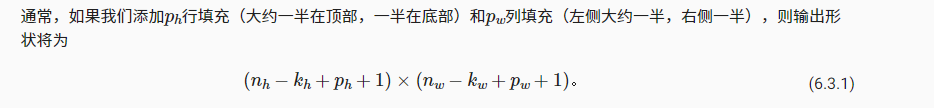
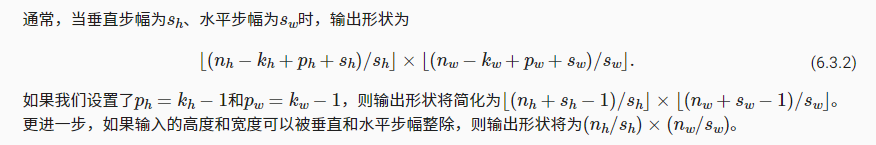

超参数（核大小，填充，步幅）重要程度排序</br>核大小一般是最关键的</br>填充通常都是核-1</br>步幅通常设为1，一般不为1是计算量太大，取2</br>

# 21 多输入多输出通道

实现多输入通道互相关运算。 简而言之，所做的就是对每个通道执行互相关操作，然后将结果相加。

In [1]:
import torch
from d2l import torch as d2l


def corr2d_multi_in(X, K):
    # 先遍历“X”和“K”的第0个维度（通道维度），再把它们加在一起
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

验证互相关运算的输出

In [7]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                  [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

计算多个通道的输出的互相关函数

In [8]:
def corr2d_multi_in_out(X, K):
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)


K = torch.stack((K, K + 1, K + 2), 0)
K

tensor([[[[0., 1.],
          [2., 3.]],

         [[1., 2.],
          [3., 4.]]],


        [[[1., 2.],
          [3., 4.]],

         [[2., 3.],
          [4., 5.]]],


        [[[2., 3.],
          [4., 5.]],

         [[3., 4.],
          [5., 6.]]]])

In [9]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1x1卷积

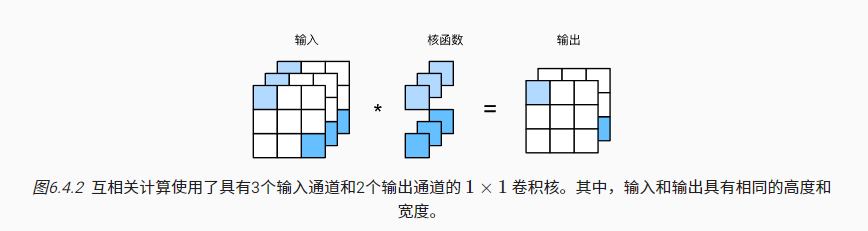

In [10]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))


X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

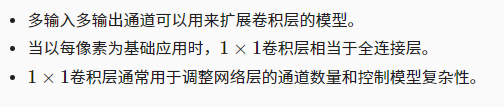

# 22 池化层 pooling

池化层返回窗口中最大或平均值</br>缓解卷积层对位置的敏感性</br>同样有窗口大小、填充、和步幅作为超参数

实现池化层的正向传播

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [3]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

填充和步幅

In [4]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

默认情况下，深度学习框架中的步幅与汇聚窗口的大小相同。 因此，如果我们使用形状为(3, 3)的汇聚窗口，那么默认情况下，我们得到的步幅形状为(3, 3)。

In [5]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

填充和步幅可以手动设定

In [6]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

在处理多通道输入数据时，汇聚层在每个输入通道上单独运算，而不是像卷积层一样在通道上对输入进行汇总。 这意味着汇聚层的输出通道数与输入通道数相同。 下面，我们将在通道维度上连结张量X和X + 1，以构建具有2个通道的输入。

In [7]:
X = torch.cat((X, X + 1), 1)  # 按第一维合并
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [8]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

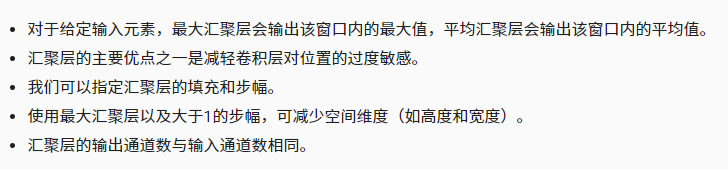